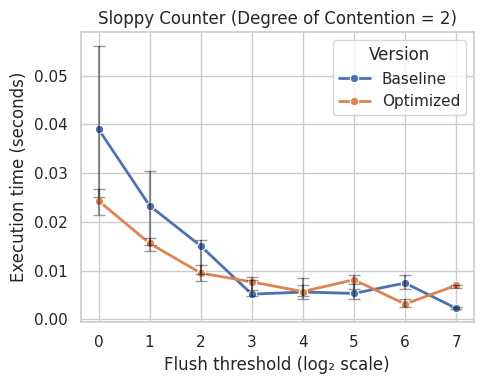

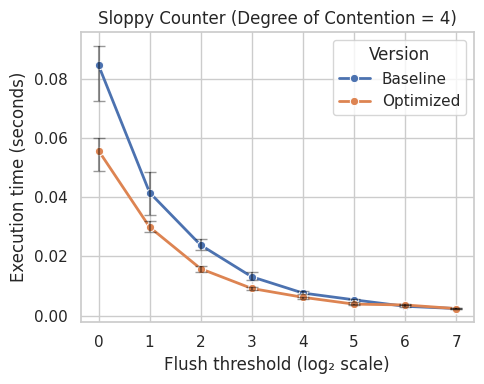

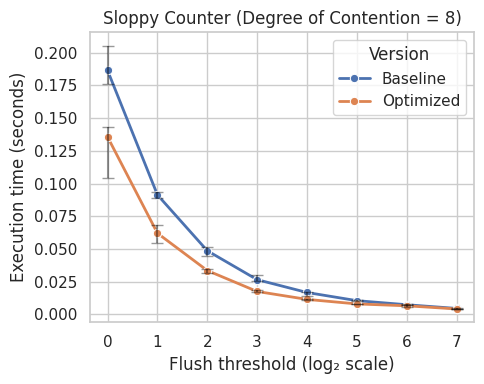

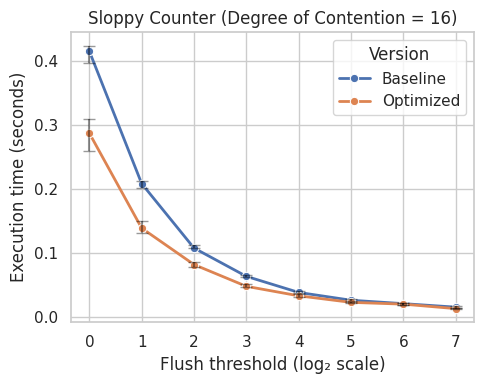

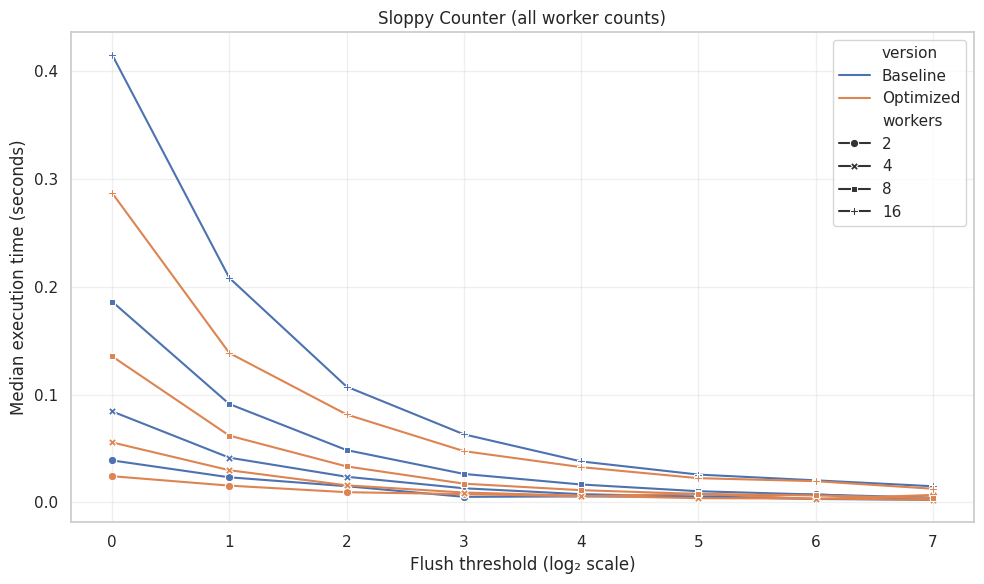

In [ ]:
# --- Sloppy Counter Benchmark Visualization ---
# Load sloppy_benchmark_workers.csv and visualize with seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# ---------- Load CSV (from results/) ----------
results_dir = "results"
csv_path = os.path.join(results_dir, "sloppy_benchmark_workers.csv")
df = pd.read_csv(csv_path)

# long format for seaborn
df_long = pd.DataFrame({
    "workers": df["workers"].tolist() * 2,
    "threshold": df["threshold"].tolist() * 2,
    "median": pd.concat([df["naive_median"], df["opt_median"]]).values,
    "p25":    pd.concat([df["naive_p25"], df["opt_p25"]]).values,
    "p75":    pd.concat([df["naive_p75"], df["opt_p75"]]).values,
    "version": ["Baseline"] * len(df) + ["Optimized"] * len(df)
})

df_long["lower_err"] = df_long["median"] - df_long["p25"]
df_long["upper_err"] = df_long["p75"] - df_long["median"]

# Use log2 threshold for aesthetics
df_long["log2_threshold"] = np.log2(df_long["threshold"])

sns.set_theme(style="whitegrid")

# ---------- One figure per worker count ----------
unique_workers = sorted(df_long["workers"].unique())

for w in unique_workers:
    d = df_long[df_long["workers"] == w]

    plt.figure(figsize=(5,4))
    ax = sns.lineplot(
        data=d,
        x="log2_threshold",
        y="median",
        hue="version",
        marker="o",
        err_style=None,
        linewidth=2
    )

    # Add error bars manually
    for _, row in d.iterrows():
        plt.errorbar(
            row["log2_threshold"],
            row["median"],
            yerr=[[row["lower_err"]], [row["upper_err"]]],
            fmt="none",
            capsize=4,
            color="black",
            alpha=0.4
        )

    plt.title(f"Sloppy Counter (Degree of Contention = {w})")
    plt.xlabel("Flush threshold (log₂ scale)")
    plt.ylabel("Execution time (seconds)")
    plt.legend(title="Version")
    plt.tight_layout()
    plt.show()

# ---------- Combined plot for all worker counts ----------
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_long,
    x="log2_threshold",
    y="median",
    hue="version",
    style="workers",
    markers=True,
    dashes=False
)

plt.title("Sloppy Counter (all worker counts)")
plt.xlabel("Flush threshold (log₂ scale)")
plt.ylabel("Median execution time (seconds)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


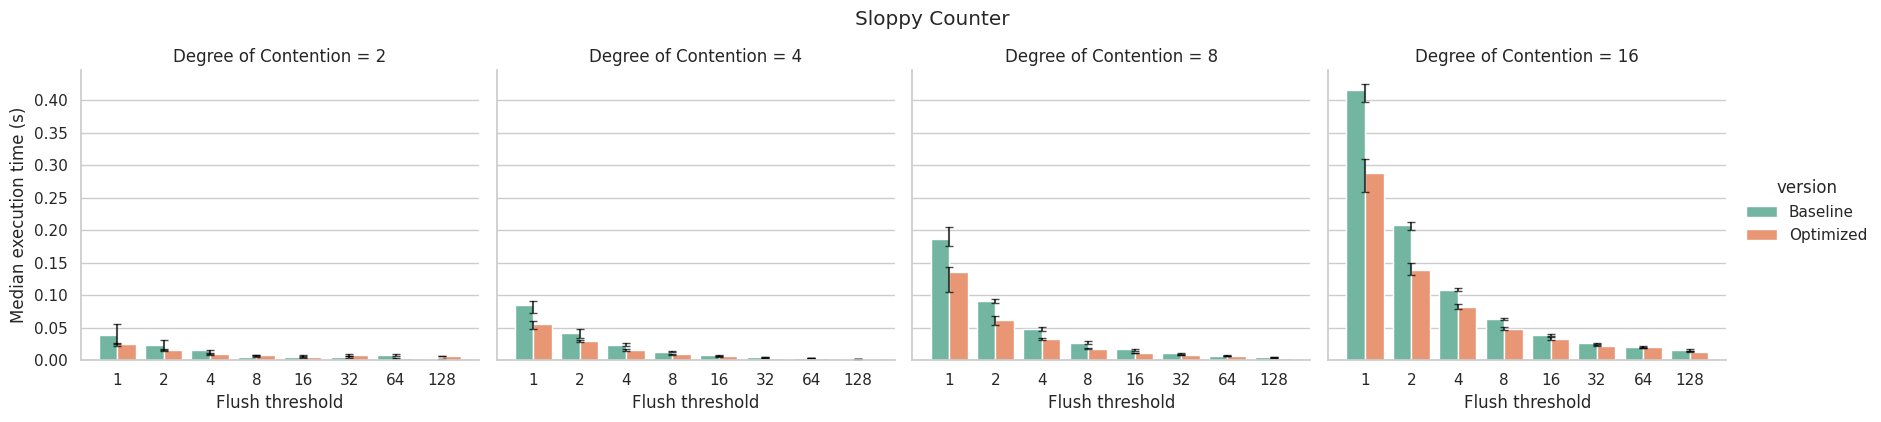

In [9]:
g = sns.catplot(
    data=df_long,
    x="threshold",
    y="median",
    hue="version",
    col="workers",
    kind="bar",
    height=4,
    aspect=1.1,
    palette="Set2",
    legend=True
)

# Add error bars manually (Seaborn doesn't auto-bar ci for custom stats)
for ax, (workers, subdf) in zip(g.axes[0], df_long.groupby("workers")):
    for i, (idx, row) in enumerate(subdf.iterrows()):
        ax.errorbar(
            x=i % len(subdf["threshold"].unique()),
            y=row["median"],
            yerr=[[row["lower_err"]], [row["upper_err"]]],
            fmt='none',
            ecolor="black",
            capsize=3,
            alpha=0.7
        )

g.set_axis_labels("Flush threshold", "Median execution time (s)")
g.set_titles("Degree of Contention = {col_name}")
g.fig.suptitle("Sloppy Counter", y=1.05)

plt.show()